# Automated Email Marketing Part #3: Getting LLMs to Sell



In this post I build on the work I did in the last post connecting LangChain to Klaviyo. In this one I experiment prompt engineering using LangChain and build an algorithm to  generate personalized emails to customers. I begin by creating chains for four essential parts of the email, write a function to build the email using those prompts, and then write a function to generate a unique email for each customer. If you already read the intial post or aren't interested in the first part as much feel free to skip ahead.

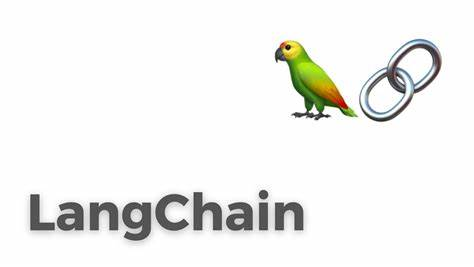

### What we did last time: Integrating Klaviyo with LangChain

In [1]:
import os
import requests
import csv
import random

from dotenv import load_dotenv
from klaviyo_api import KlaviyoAPI

from langchain.prompts import PromptTemplate
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import (RunnablePassthrough, RunnableLambda, RunnableParallel)

In [2]:
_ = load_dotenv()

In [3]:
# Extract Klaviyo (private) API key from .env file
klaviyo_key=...

In [4]:
# Instantiate the Klaviyo Python API with the API key

klaviyo = KlaviyoAPI(klaviyo_key, max_delay=60, max_retries=3, test_host=None)

In [5]:
# Extract a sample of Metrics from the Klaviyo API

klaviyo.Metrics.get_metrics()

{'data': [{'type': 'metric',
   'id': 'R8A4y9',
   'attributes': {'name': 'Subscribed to SMS Marketing',
    'created': '2024-04-15T00:48:21+00:00',
    'updated': '2024-04-15T00:48:21+00:00',
    'integration': {'object': 'integration',
     'id': '0rG4eQ',
     'key': 'klaviyo',
     'name': 'Klaviyo',
     'category': 'Internal'}},
   'links': {'self': 'https://a.klaviyo.com/api/metrics/R8A4y9/'}},
  {'type': 'metric',
   'id': 'RKB7aL',
   'attributes': {'name': 'Received SMS',
    'created': '2024-04-15T00:48:21+00:00',
    'updated': '2024-04-15T00:48:21+00:00',
    'integration': {'object': 'integration',
     'id': '0rG4eQ',
     'key': 'klaviyo',
     'name': 'Klaviyo',
     'category': 'Internal'}},
   'links': {'self': 'https://a.klaviyo.com/api/metrics/RKB7aL/'}},
  {'type': 'metric',
   'id': 'RQemwa',
   'attributes': {'name': 'Clicked email to unsubscribe',
    'created': '2024-04-15T00:48:17+00:00',
    'updated': '2024-04-15T00:48:17+00:00',
    'integration': {'object

In [6]:
klaviyo.Events.get_events()

{'data': [{'type': 'event',
   'id': '5aqJhKtQPcL',
   'attributes': {'timestamp': 1713735711,
    'event_properties': {'email_address': 'egnition_sample_72@egnition.com',
     'method': 'LIST_IMPORT',
     'method_detail': 'maxo.philly@gmail.com',
     'custom_method_detail': None,
     'double_optin': False,
     'list_id': 'YnUQVt',
     'list_name': 'Newsletter',
     '$event_id': '01HVFMJSPXX0W8DVR30YR1T37QS688yk1713735711'},
    'datetime': '2024-04-21T21:41:51+00:00',
    'uuid': 'f66f7980-0027-11ef-8001-eb7a73e8c794'},
   'relationships': {'profile': {'data': {'type': 'profile',
      'id': '01HVFMJSPXX0W8DVR30YR1T37Q'},
     'links': {'self': 'https://a.klaviyo.com/api/events/5aqJhKtQPcL/relationships/profile/',
      'related': 'https://a.klaviyo.com/api/events/5aqJhKtQPcL/profile/'}},
    'metric': {'data': {'type': 'metric', 'id': 'W2XfDk'},
     'links': {'self': 'https://a.klaviyo.com/api/events/5aqJhKtQPcL/relationships/metric/',
      'related': 'https://a.klaviyo.com/a

In [7]:
# Store a sample customer ID from Klaviyo in an object

karine_ruby="01HVFKKSPHKNC5PV0VNN14TSJ4"

In [8]:
profile=klaviyo.Profiles.get_profile(karine_ruby)
profile

{'data': {'type': 'profile',
  'id': '01HVFKKSPHKNC5PV0VNN14TSJ4',
  'attributes': {'email': 'karine.ruby@example.com',
   'phone_number': '+16135550142',
   'external_id': None,
   'anonymous_id': None,
   'first_name': 'Karine',
   'last_name': 'Ruby',
   'organization': None,
   'title': None,
   'image': None,
   'created': '2024-04-15T00:48:18+00:00',
   'updated': '2024-04-24T01:00:57+00:00',
   'last_event_date': '2024-04-21T21:41:50+00:00',
   'location': {'zip': None,
    'latitude': None,
    'longitude': None,
    'country': None,
    'address1': None,
    'address2': None,
    'region': None,
    'city': None,
    'timezone': None,
    'ip': None},
   'properties': {'Accepts Marketing': True,
    'Shopify Tags': [],
    'clv': 1000,
    'churn_risk': 'high',
    'upsales_propensity': '80%',
    'recommended_incentive': 'gift',
    '$consent': ['email'],
    '$source': -6,
    '$consent_timestamp': '2024-04-21T21:41:48.951Z'}},
  'relationships': {'lists': {'links': {'self':

In [9]:
# From here we can update a profile with custom properties

payload={ "data": {
        "type": "profile",
        "id": karine_ruby,
        "attributes": {
            'properties':{
                'clv':500,
                'churn_risk':'high',
                'upsales_propensity': '80%',
                'recommended_incentive': 'gift'
            }
                    }
            }
     }

klaviyo.Profiles.update_profile(karine_ruby, payload)

{'data': {'type': 'profile',
  'id': '01HVFKKSPHKNC5PV0VNN14TSJ4',
  'attributes': {'email': 'karine.ruby@example.com',
   'phone_number': '+16135550142',
   'external_id': None,
   'anonymous_id': None,
   'first_name': 'Karine',
   'last_name': 'Ruby',
   'organization': None,
   'title': None,
   'image': None,
   'created': '2024-04-15T00:48:18+00:00',
   'updated': '2024-04-24T01:00:57+00:00',
   'last_event_date': '2024-04-21T21:41:50+00:00',
   'location': {'city': None,
    'address1': None,
    'zip': None,
    'longitude': None,
    'country': None,
    'region': None,
    'address2': None,
    'latitude': None,
    'timezone': None,
    'ip': None},
   'properties': {'Accepts Marketing': True,
    'Shopify Tags': [],
    'clv': 500,
    'churn_risk': 'high',
    'upsales_propensity': '80%',
    'recommended_incentive': 'gift',
    '$consent': ['email'],
    '$source': -6,
    '$consent_timestamp': '2024-04-21T21:41:48.951Z'}},
  'relationships': {'lists': {'links': {'self': 

In [10]:
profile=klaviyo.Profiles.get_profile(karine_ruby)
print(profile.keys())  # This will show you all the top-level keys in the `profile` dictionary.
data = profile['data']

dict_keys(['data'])


In [11]:
data.keys()

dict_keys(['type', 'id', 'attributes', 'relationships', 'links'])

In [12]:
data['attributes']

{'email': 'karine.ruby@example.com',
 'phone_number': '+16135550142',
 'external_id': None,
 'anonymous_id': None,
 'first_name': 'Karine',
 'last_name': 'Ruby',
 'organization': None,
 'title': None,
 'image': None,
 'created': '2024-04-15T00:48:18+00:00',
 'updated': '2024-04-24T01:02:36+00:00',
 'last_event_date': '2024-04-21T21:41:50+00:00',
 'location': {'region': None,
  'address2': None,
  'longitude': None,
  'zip': None,
  'address1': None,
  'latitude': None,
  'city': None,
  'country': None,
  'timezone': None,
  'ip': None},
 'properties': {'Accepts Marketing': True,
  'Shopify Tags': [],
  'clv': 500,
  'churn_risk': 'high',
  'upsales_propensity': '80%',
  'recommended_incentive': 'gift',
  '$consent': ['email'],
  '$source': -6,
  '$consent_timestamp': '2024-04-21T21:41:48.951Z'}}

In [13]:
# Extract profile data and events for a Klaviyo ID as a string we can feed to LangChain

def get_customer_data(custid):
    profile=klaviyo.Profiles.get_profile(custid)
    data = profile['data']
    attributes = data['attributes']
    properties = attributes['properties']
    location = attributes['location']
    info = {key: value for key, value in attributes.items() if key not in ['properties', 'location']}
    combined_dict = {**properties, **location, **info}
    return combined_dict

In [14]:
data = get_customer_data('01HVFMJSDSK7YF1K052T4S0M44',)
data

{'Accepts Marketing': True,
 'Shopify Tags': ['egnition-sample-data', 'referral'],
 '$consent': ['email'],
 '$source': -6,
 '$consent_timestamp': '2024-04-21T21:41:50.728Z',
 'clv': 1000,
 'churn_risk': 'high',
 'upsales_propensity': '50%',
 'recommended_incentive': 'coupon',
 'address1': 'Ap #336-7706 Vehicula Rd.',
 'zip': '54239',
 'city': 'Benalla',
 'address2': None,
 'latitude': None,
 'country': 'Kyrgyzstan',
 'longitude': None,
 'region': None,
 'timezone': None,
 'ip': None,
 'email': 'egnition_sample_62@egnition.com',
 'phone_number': '+996315877102',
 'external_id': None,
 'anonymous_id': None,
 'first_name': 'John',
 'last_name': 'Conway',
 'organization': None,
 'title': None,
 'image': None,
 'created': '2024-04-15T01:05:13+00:00',
 'updated': '2024-04-24T01:00:58+00:00',
 'last_event_date': '2024-04-21T21:41:51+00:00'}

### This time: Prompt Engineering in LangChain

For the prompt I'll be using the inverted pyramid framework, building each individual part as its own individual chain. The inverted pyramid framework popular with marketers and journalists because of its focus on grabbing and holding a readers attention. There are many variants of it, but at its most basic form the inverted pyramid grabs the attention of a potential customer, builds anticipation about a product or service and then expresses a powerful call to action to convert the customer. Using LangChain we can isolate the individual parts of this pyramid to guarantee each part of the conversion funnel will be written according to its respective purpose and style.

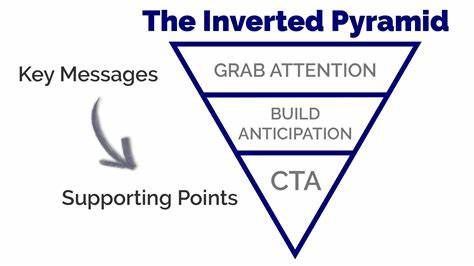

### Writing Chains

In [15]:
data.keys()

dict_keys(['Accepts Marketing', 'Shopify Tags', '$consent', '$source', '$consent_timestamp', 'clv', 'churn_risk', 'upsales_propensity', 'recommended_incentive', 'address1', 'zip', 'city', 'address2', 'latitude', 'country', 'longitude', 'region', 'timezone', 'ip', 'email', 'phone_number', 'external_id', 'anonymous_id', 'first_name', 'last_name', 'organization', 'title', 'image', 'created', 'updated', 'last_event_date'])

In [16]:
grab_attention = ChatPromptTemplate.from_template(
    '''
Write a short 2 line introduction to an email with a hook from Max's Store to {first_name}. The email should be pitching the release and special offer of a new line of shoes called the MegaShoe 1s. Write it according to the following rules:
- Infer gender and age from {first_name} and tailor your style to who you're addressing
- If the customer has a high {clv}, offer them a better deal than a customer with a lower {clv}
- If a customer has a high {churn_risk} use more urgent wording in your hook
- If a customer has a higher {upsales_propensity} offer a more expensive product
- Tease the {recommended_incentive}
    
Remember not to mention these properties explicitly, but craft your message to resonate with these insights.
No emojis and keep it short and simple. Write like a 7th grader to ensure your email is easily understood by a wide audience.
Get creative, don't just fall into bland platitudes, and you don't have to follow the examples but use them to guide you.
ONLY WRITE ONE DRAFT
__

Examples: 
Hi Doug, We're excited to introduce our new product, the MegaShoe 1s, and we're offering you an exclusive 20% discount for a limited time as one of our valued customers!
Hi Debby, Get ready to upgrade your style with our latest innovation - the MegaShoe 1s Supreme! As a loyal customer, we're offering you a special deal of buy one, get one 50% off for a limited time only.
Hi Kendrick, Don't miss out on our newest arrival - the MegaShoe 1s Pro! With its advanced features and sleek design, it's a must-have for anyone on-the-go. And as a valued customer, we're giving you an exclusive 30% off your first purchase.

'''
)

build_anticipation = ChatPromptTemplate.from_template(
    '''
Write an the body of an email from Max's Store to a customer following up on the introduction of the new MegaShoe 1s. The body should:
- Establish the customer's need for a new shoe alternative
- Emphasize the key features and benefits of the MegaShoe 1s
- Highlight the special offer and create a sense of urgency
- Encourage the customer to take action and make a purchase
- Infer gender and age from {first_name} and tailor your style to who you're addressing
- Consider the customer's {clv}, {churn_risk}, and {upsales_propensity} to tailor the tone and content
    
Remember not to mention these properties explicitly, but craft your message to resonate with these insights.
No emojis and keep it short and simple. Write like a 7th grader to ensure your email is easily understood by a wide audience.
Get creative, don't just fall into bland platitudes, and you don't have to follow the examples but use them to guide you.
DO NOT MENTION THE CUSTOMER'S NAME HERE. YOU ARE WRITING ONE BODY PARAGRAPH NOT AN INTRO OR CONCLUSION. LITERALLY JUST ONE PARAGRAPH.
ONLY WRITE ONE DRAFT
__

Examples:
- We've just launched our revolutionary MegaShoe 1s, designed to keep you comfortable and confident all day long. Whether you're hitting the gym or running errands, these shoes have got you covered. Here's what you need to know: Comfort and support: Soft materials and arch support for happy feet. Stylish and versatile: Cute design that looks great for any occasion. Durable and long-lasting: Built to withstand your active lifestyle. 
- Sick of wearing out your favorite kicks too fast? We feel you! That's why we created the MegaShoe 1s - the ultimate shoe for the active dude on the go! These bad boys are packed with: Comfy tech: Cushioning and breathability for happy feet. Supportive vibes: Stability features for high-impact activities. Fresh style: Sleek design that's perfect for the gym or just chillin'.
- Are you tired of wearing out your favorite shoes too quickly? Do you need a new go-to pair that can keep up with your active lifestyle? We've got you covered! Our brand-new MegaShoe 1s are designed to provide unparalleled comfort, support, and durability. With their cutting-edge technology and sleek design, they're perfect for fitness enthusiasts like yourself. Here's what sets them apart: Long-lasting comfort: Breathable materials and cushioning ensure your feet stay happy all day. Superior support: Stability features and arch support for high-impact activities. Style and versatility: Sleek design that looks great for both workouts and everyday wear. 
'''
)

call_to_action = ChatPromptTemplate.from_template(
    '''
Craft a compelling call to action that directs the customer on what to do next. Use actionable language that conveys urgency and benefit. Ensure the call to action is simple, direct, and easy to follow. 
- Infer gender and age from {first_name} and tailor your style to who you're addressing
- Consider the customer's {clv}, {churn_risk}, and {upsales_propensity} to tailor the tone and content
- Offer the {recommended_incentive}
- Be decisive and confident

Remember not to mention these properties explicitly, but craft your message to resonate with these insights.
No emojis and keep it short and simple. Write like a 7th grader to ensure your email is easily understood by a wide audience.
Get creative, don't just fall into bland platitudes, and you don't have to follow the examples but use them to guide you.
DO NOT MENTION THE CUSTOMER'S NAME HERE.
ONLY WRITE ONE DRAFT
__   

Example:
- Don't Miss Out! Grab 10% off your first MegaShoe 1s purchase and get the comfort and support you need. Limited time offer - Shop Now and Get Moving! Best Regards, Your Friends at Max's Store
- Treat Yourself to the Best! Enjoy 12% off your first MegaShoe 1s purchase and discover the perfect blend of style and comfort. Shop Now and Elevate Your Everyday! Sincerely, your friends at Max's Store
- Upgrade Your Shoe Game Now! Get 15% off your first MegaShoe 1s purchase and experience the ultimate in comfort and performance. Shop Now and Take Your Fitness to the Next Level! Warmly, your friends at Max's Store
    '''
)

subject_line = ChatPromptTemplate.from_template(
    '''
Write a short but eye-catching subject line to an email from Max's Store mentioning the customer by {first_name} and the {recommended_incentive}.
- No emojis and keep it short and simple. Write like a 7th grader to ensure your email is easily understood by a wide audience.
- Get creative, don't just fall into bland platitudes, and you don't have to follow the examples but use them to guide you.
- ONLY WRITE ONE DRAFT
__

Examples:
- Billy, 24 Hours to Claim Your Exclusive Gift!
- Hey Megan, We've Got a Shoe-tastic Deal for You! Coupon Inside!
- AJ, Unlock Your VIP Access: Free Shipping on MegaShoe 1s Awaits
    '''
)

In [17]:
# Create the chat model:
model = ChatOpenAI(model_name="gpt-4", temperature=0.2)

# Create the sub-chains:
grab_attention_chain = (grab_attention | model | StrOutputParser())

build_anticipation_chain = (build_anticipation | model | StrOutputParser())

call_to_action_chain = (call_to_action | model | StrOutputParser())

subject_line_chain = (subject_line | model | StrOutputParser())

/usr/local/anaconda3/share/jupyter/venv/py311_4130_v2/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


### Create a Function That Builds One Email from the Chains

In [18]:
# define a function that generates an email for a given customer based on their Klaviyo ID
def generate_email(custid):
    
    # Fetch customer data
    customer_data = get_customer_data(custid)
    
    # Execute sub-chains
    attention_text = grab_attention_chain.invoke(customer_data)
    anticipation_text = build_anticipation_chain.invoke(customer_data)
    action_text = call_to_action_chain.invoke(customer_data)
    subject = subject_line_chain.invoke(customer_data)

    # Combine the outputs to form the complete email
    email = f"{subject}\n\n{attention_text}\n\n{anticipation_text}\n\n{action_text}"

    return email

sample_email = generate_email('01HVFMJSDSK7YF1K052T4S0M44')
print(sample_email)


"John, Your Exclusive Max's Store Coupon is Waiting!"

Hello John, Step into the future with our brand new MegaShoe 1s, designed to redefine comfort and style. As a token of our appreciation for your loyalty, we're offering you an exclusive deal that you won't want to miss - stay tuned for a special coupon in this email!

Tired of shoes that just can't keep up with your active lifestyle? We've got the perfect solution for you! Introducing our new MegaShoe 1s, the ultimate footwear designed to provide you with unparalleled comfort, support, and durability. These shoes are packed with features that make them a game-changer: they offer long-lasting comfort with their breathable materials and cushioning, superior support with stability features and arch support for high-impact activities, and a sleek design that looks great for both workouts and everyday wear. But that's not all - for a limited time, we're offering a special 50% off on your first pair! This is a deal you don't want to miss

### Create Dictionary with Final Email and Address to Send to

In [19]:
# Get profiles from Klaviyo into a dictionary
profiles = klaviyo.Profiles.get_profiles()

# Initialize an empty list to store customer IDs
cust_ids = []

# Iterate over profiles and extract customer IDs
for profile in profiles['data']:
    cust_ids.append(profile['id'])

cust_ids

['01HVFKKS3976M2BYYKRH2YE5BW',
 '01HVFKKSM9HTV1TPEASMH694MG',
 '01HVFKKSPHKNC5PV0VNN14TSJ4',
 '01HVFKKVK1HECSCYB6VVGHSSRQ',
 '01HVFMJRBBN12VGRB95NHWKBTS',
 '01HVFMJREQ54N2M732CSFX450J',
 '01HVFMJS7THFNM4R99JRWKFS1T',
 '01HVFMJSDSK7YF1K052T4S0M44',
 '01HVFMJSP8CEQK5V0YFT85VYDE',
 '01HVFMJSPXX0W8DVR30YR1T37Q',
 '01HVFMJTF6C2WHD7J4MZ5R9PAX',
 '01HVFMJTRJVBPBCY763A4M35F7',
 '01HVFMJV39QFH8AYF7D11B0KWD',
 '01HVFMJV9JTCGPE7CAYEJ6X11T']

In [20]:
def update_customer_profiles(cust_ids):
    churn_risks = ['low', 'medium', 'high']
    upsales_propensities = ['20%', '50%', '80%']
    recommended_incentives = ['gift', 'coupon', 'discount']
    clv_values = [100, 500, 1000]

    emails = {}

    for custid in cust_ids:
        custid_str = str(custid)  # Ensure the custid is a string
        # Generate random properties
        properties = {
            'clv': random.choice(clv_values),
            'churn_risk': random.choice(churn_risks),
            'upsales_propensity': random.choice(upsales_propensities),
            'recommended_incentive': random.choice(recommended_incentives)
        }

        # Prepare the payload for the API call
        payload = {
            "data": {
                "type": "profile",
                "id": custid_str,
                "attributes": {
                    'properties': properties
                }
            }
        }

        # Update the profile
        klaviyo.Profiles.update_profile(custid_str, payload)
        print(f"Updated profile for ID {custid_str} with properties: {properties}")

# Assuming cust_ids is a list of customer IDs
update_customer_profiles(cust_ids)

Updated profile for ID 01HVFKKS3976M2BYYKRH2YE5BW with properties: {'clv': 1000, 'churn_risk': 'medium', 'upsales_propensity': '80%', 'recommended_incentive': 'coupon'}
Updated profile for ID 01HVFKKSM9HTV1TPEASMH694MG with properties: {'clv': 500, 'churn_risk': 'medium', 'upsales_propensity': '20%', 'recommended_incentive': 'gift'}
Updated profile for ID 01HVFKKSPHKNC5PV0VNN14TSJ4 with properties: {'clv': 1000, 'churn_risk': 'low', 'upsales_propensity': '80%', 'recommended_incentive': 'coupon'}
Updated profile for ID 01HVFKKVK1HECSCYB6VVGHSSRQ with properties: {'clv': 1000, 'churn_risk': 'high', 'upsales_propensity': '50%', 'recommended_incentive': 'gift'}
Updated profile for ID 01HVFMJRBBN12VGRB95NHWKBTS with properties: {'clv': 100, 'churn_risk': 'high', 'upsales_propensity': '20%', 'recommended_incentive': 'discount'}
Updated profile for ID 01HVFMJREQ54N2M732CSFX450J with properties: {'clv': 1000, 'churn_risk': 'high', 'upsales_propensity': '80%', 'recommended_incentive': 'discount

In [21]:
type(cust_ids[0])

str

In [22]:
emails = []

for customer_id in cust_ids:
    message = generate_email(customer_id)  # Generate the email from the data directly, without fetching again
    emails.append(message)
    
print(emails)


['"Russell, Your Personalized Coupon from Max\'s Store is Here!"\n\nHey Russell, Time is running out to snag our latest sensation - the MegaShoe 1s Deluxe! As one of our top-tier customers, we\'re offering you an unbeatable deal you won\'t want to miss. Stay tuned for your exclusive coupon!\n\nAre you on the hunt for a new pair of kicks that can keep up with your active lifestyle? Look no further! Our newly launched MegaShoe 1s are the perfect blend of comfort, durability, and style. These shoes are designed with soft, breathable materials that provide all-day comfort and arch support to keep your feet happy. Plus, their robust construction ensures they can withstand the rigors of your daily activities. But that\'s not all - they also boast a sleek design that\'s versatile enough for the gym, the office, or a night out. And here\'s the kicker - for a limited time, we\'re offering a special deal on the MegaShoe 1s. But hurry, this offer won\'t last long! So, why wait? Step up your shoe 

In [23]:
with open('emails.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Emails"])  # header row
    for email in emails:
        writer.writerow([email])

The details of the results and possible implications will be explored deeper in the next post